# Introduction

This notebook guides through calibration function development using published data (S. De Vito et al., Sensors and Actuators B: Chemical, Volume 129, Issue 2).

In [2]:
# Load libriaries.
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, validation_curve, learning_curve
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error
from sklearn.inspection import permutation_importance, partial_dependence
from sklearn.decomposition import FastICA, KernelPCA

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['lines.linewidth'] = 1.0
plt.rcParams['font.size'] = 6.0
plt.rcParams['axes.titlesize'] = 6.0

# Method(s)
A neural network is used as machine learning algorithm. To avoid overfitting, a randomized grid search over regularization parameter and neural network architecture is performed.

In [20]:
# Define helper functions.
transformer = PolynomialFeatures(degree=2, include_bias=False)
scaler = StandardScaler(copy=True) # Define standard scaler instance.
imputer = SimpleImputer() # Define imputer instance.
detector = IsolationForest(n_estimators=1000, random_state=0) # Define outlier detector instance.
dim_red = KernelPCA(n_components=2, kernel="rbf", random_state=0, n_jobs=-1) # Define dimensionality reduction instance.
model = Ridge(normalize=False, random_state=0) # Define random forest model instance.
lin_reg = LinearRegression() # Define linear regression instance.

# Define label generator for transformer.
def generate_labels(transformer):
    labels = []
    for row in transformer.powers_:
        current_label = ""
        for i, power in enumerate(row):
            if power > 1:
                current_label += inputs[i]+r"$^"+str(power)+r"$"+r"$\cdot$"
            elif power > 0:
                current_label += inputs[i]+r"$\cdot$"
        labels.append(current_label[:-7])
    return labels

# Data Handling
Load data to pandas data frame.

In [21]:
# Load data and keep only first six months.
data = pd.read_excel("data.xlsx")
data = data[data["Date"] <= "2004-09-10"]

# Visualize data summary.
data.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,3447.000000,4275.000000,914.000000,4275.000000,4275.000000,3525.000000,4275.000000,3522.000000,4275.000000,4275.000000,4275.000000,4275.000000,4275.000000
mean,1.918422,1077.334113,218.811816,9.850661,937.848090,126.051348,897.271150,94.706133,1617.936394,944.460370,23.451201,42.485045,1.153040
std,1.206673,200.344215,204.459921,6.566329,240.489984,83.970746,228.686816,36.637686,255.788785,343.175279,7.843419,15.985736,0.343338
min,0.100000,708.000000,7.000000,0.464418,437.000000,2.000000,387.500000,5.000000,955.000000,263.000000,6.100000,9.175000,0.375444
25%,1.000000,932.250000,67.000000,4.843458,755.500000,63.000000,735.875000,67.000000,1441.750000,692.875000,17.300000,29.500000,0.904255
50%,1.700000,1047.500000,150.000000,8.499723,919.500000,108.000000,860.000000,94.000000,1587.000000,896.500000,23.450000,42.500000,1.096318
75%,2.500000,1184.250000,297.000000,13.385657,1096.500000,168.000000,1022.750000,119.000000,1752.625000,1150.625000,28.600000,54.000000,1.366492
max,8.100000,2039.750000,1189.000000,40.260061,1776.250000,631.000000,1940.750000,233.000000,2746.000000,2474.750000,44.600000,85.150002,2.180639


# Preprocessing
The data is preprocessed and sliced into different sets. Data is scaled before analysis. In particular, standard scaling provides better results with respect to R2 score and explained variance.
No imputation is performed.

In [22]:
# Select columns and remove rows with missing values.
columns = ["PT08.S1(CO)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)", "T", "AH", "CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]
inputs = ["PT08.S1(CO)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)", "T", "AH"]
outputs = ["CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]
data = data[columns].dropna(axis=0)

# Create polynomial features.
X_p = transformer.fit_transform(data[inputs]) # Fit and transform.

# Restore array with inputs and outputs.
X_t = np.concatenate((X_p, data[outputs].values), axis=1)

# Scale data to zero mean and unit variance.
X_t = scaler.fit_transform(X_t)

# Optional: Impute missing values.
# X_t = imputer.fit_transform(X_t)

# Remove outliers.
is_inlier = detector.fit_predict(X_t)
X_t = X_t[(is_inlier > 0),:]

# Rename columns.
inputs = [item.split("(")[-1].split(")")[0] for item in inputs] # Keep labeling uncluttered.
inputs = generate_labels(transformer) # Rename inputs.
columns = inputs+outputs

# Restore frame.
data = pd.DataFrame(X_t, columns=columns)

In [25]:
# Assign training data.
X = data[inputs]
Y = data[outputs]

# Perform slicing into training and test set.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=0)
print("Training set consists of", X_train.shape[0], "samples. Test set contains", X_test.shape[0], "samples.")

Training set consists of 1917 samples. Test set contains 822 samples.


# Training
Hyperparameters are determined via randomized grid search and model is trained.

In [7]:
# Training phase.
parameters = {"alpha": np.logspace(-2, 2, 50)} # Define grid. 
clf = RandomizedSearchCV(model, parameters, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=0) # Run grid search.
clf.fit(X_train, Y_train) # Train/optimize regressor.
model1 = clf.best_estimator_ # Select best model.

# Results and Discussion

The model with shuffled data is better with respect to the metrics.

In [8]:
# Evaluate second model in testing phase.
Y_predict = model1.predict(X_test) # Predict.
exp = explained_variance_score(Y_test, Y_predict) 
r2 = r2_score(Y_test, Y_predict)
mse = mean_squared_error(Y_test, Y_predict)
print("Explained variance is", np.round(exp, 2), ", R2 score is", np.round(r2, 2), ", and MSE is", np.round(mse, 2), ".")

Explained variance is 0.85 , R2 score is 0.85 , and MSE is 0.1 .


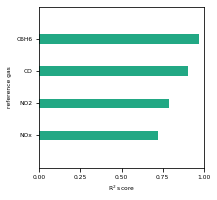

In [9]:
# Compute individual R2 scores.
r2_ = r2_score(Y_test, Y_predict, multioutput="raw_values")
labels = [item[:-4] for item in Y.columns]

# Plot individual R2 scores.
fig = plt.figure(figsize=(2.95,2.95))
fig.tight_layout()
plt.barh(range(len(r2_)), r2_[r2_.argsort()], color=plt.cm.viridis(0.6), ecolor=plt.cm.viridis(0.3), 
         height=0.3, xerr=None, align="center", alpha=1.0)
plt.yticks(range(len(r2_)), np.array(labels)[r2_.argsort()],rotation=0)
plt.xticks((0,0.25,0.5,0.75,1.0))
plt.ylim([-1, len(r2_)])
plt.xlim([0, 1.0])
plt.xlabel("R$^2$ score")
plt.ylabel("reference gas")
plt.savefig('./figures/R2',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

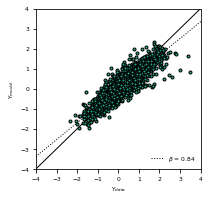

In [10]:
# Determine slope.
slope = lin_reg.fit(Y_test.values.flatten().reshape(-1, 1), Y_predict.flatten().reshape(-1, 1))

# Perform predictions.
Y_syn = np.linspace(-10, 10, 10)
Y_syn_p = slope.predict(Y_syn.reshape(-1, 1))

# Plot predictions vs. true values.
fig = plt.figure(figsize=(2.95,2.95))
fig.tight_layout()
ax = fig.add_subplot(111)
ax.set_xlabel(r"Y$_{data}$")
ax.set_ylabel(r"Y$_{model}$")
ax.set_xlim(-4.0, 4.0)
ax.set_ylim(-4.0, 4.0)
ax.plot(Y_syn,Y_syn_p, ":", color="k", label=r"$\beta$ = "+str(np.round(slope.coef_[0][0],2)))
ax.plot([-10,10],[-10,10], "-", color="k")
ax.plot(Y_test.values, Y_predict, color=plt.cm.viridis(0.6), marker=".", alpha=1.0, mec='k', linestyle="")
plt.legend(frameon=False, loc=4)
plt.savefig('./figures/congruency',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

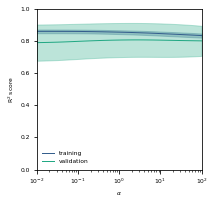

In [15]:
# Compute validation curve.
param_range = np.logspace(-2, 2, 50)
train_scores, test_scores = validation_curve(model1, X, Y, 
                                             "alpha", param_range, cv=10, 
                                             scoring="r2", verbose=0, n_jobs=-1)

# Plot validation curve.
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(2.95,2.95))
fig.tight_layout()
ax = fig.add_subplot(111)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("R$^2$ score")
ax.set_ylim(0.0, 1.0)
ax.set_xlim(param_range[0], param_range[-1])
plt.semilogx(param_range, train_scores_mean, label="training",color=plt.cm.viridis(0.3))
plt.fill_between(param_range, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.3,color=plt.cm.viridis(0.3))
plt.semilogx(param_range, test_scores_mean, label="validation",color=plt.cm.viridis(0.6))
plt.fill_between(param_range, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.3,color=plt.cm.viridis(0.6))
plt.legend(frameon=False, loc=3)
plt.savefig('./figures/validation_curve',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

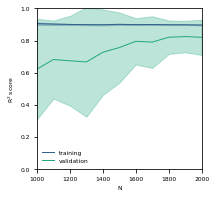

In [17]:
# Compute training curve.
train_sizes, train_scores, test_scores = learning_curve(model1, X, Y, 
                                                        train_sizes=np.linspace(1000, 2000, 11, dtype="int"), 
                                                        scoring="r2", cv=10, verbose=0, n_jobs=-1)

# Plot training curve.
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(2.95,2.95))
fig.tight_layout()
ax = fig.add_subplot(111)
ax.set_xlabel(r"N")
ax.set_ylabel("R$^2$ score")
ax.set_ylim(0.0, 1.0)
ax.set_xlim(train_sizes[0], train_sizes[-1])
plt.plot(train_sizes, train_scores_mean, label="training",color=plt.cm.viridis(0.3))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.3,color=plt.cm.viridis(0.3))
plt.plot(train_sizes, test_scores_mean, label="validation",color=plt.cm.viridis(0.6))
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.3,color=plt.cm.viridis(0.6))
plt.legend(frameon=False, loc=3)
plt.savefig('./figures/training_curve',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

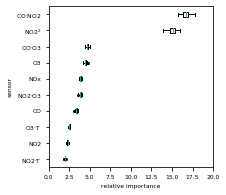

In [35]:
# Compute and plot permutation importance.
importance = permutation_importance(model1, X_train, Y_train, n_repeats=100, scoring="r2", random_state=0) # Compute.
perm_sorted_idx = importance.importances_mean.argsort() # Sort labels.

labels_ = [item for item in X_test.columns[perm_sorted_idx]] # Customize labels.

fig = plt.figure(figsize=(2.95,2.95))
fig.tight_layout()
bp = plt.boxplot(importance.importances[perm_sorted_idx].T, vert=False, labels=labels_,
           flierprops=dict(markersize=4, markerfacecolor='k',marker='.'), widths=0.3)
plt.setp(bp['medians'], color=plt.cm.viridis(0.6))
plt.xlabel("relative importance")
plt.ylabel("sensor")
plt.xlim((0, 20))
plt.ylim((len(labels_)-9.5, len(labels_)+0.5))
plt.savefig('./figures/permutation_importance',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

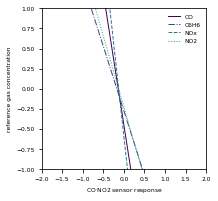

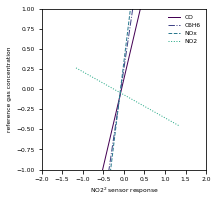

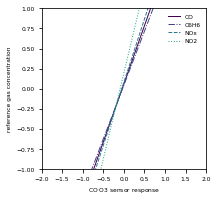

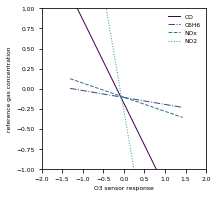

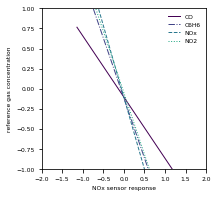

In [42]:
# Compute and plot partial dependences.
linestyles = ["-","-.","--",":"]

for i, l in enumerate(labels_[::-1][0:5]):
    y_, x_ = partial_dependence(model1, X, l)
    fig = plt.figure(figsize=(2.95,2.95))
    colors = plt.cm.Wistia(np.linspace(0,1,4))
    for k, label in enumerate(Y.columns):
        plt.plot(x_[0], y_[k].ravel(), linestyles[k], color=plt.cm.viridis((k)*1/5), label=label[:-4])
    plt.xlabel(l+" sensor response")
    plt.ylabel("reference gas concentration")
    plt.legend(loc=0,frameon=False)
    plt.xlim((-2.0,2.0))
    plt.ylim((-1.0,1.0))
    plt.savefig("./figures/pdp_"+str(i), dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
    plt.show()